In [7]:
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt


Total images loaded: 5834
Category counts:
TRAIN/NORMAL: 1341
TRAIN/PNEUMONIA: 3859
TEST/NORMAL: 231
TEST/PNEUMONIA: 387
VAL/NORMAL: 8
VAL/PNEUMONIA: 8


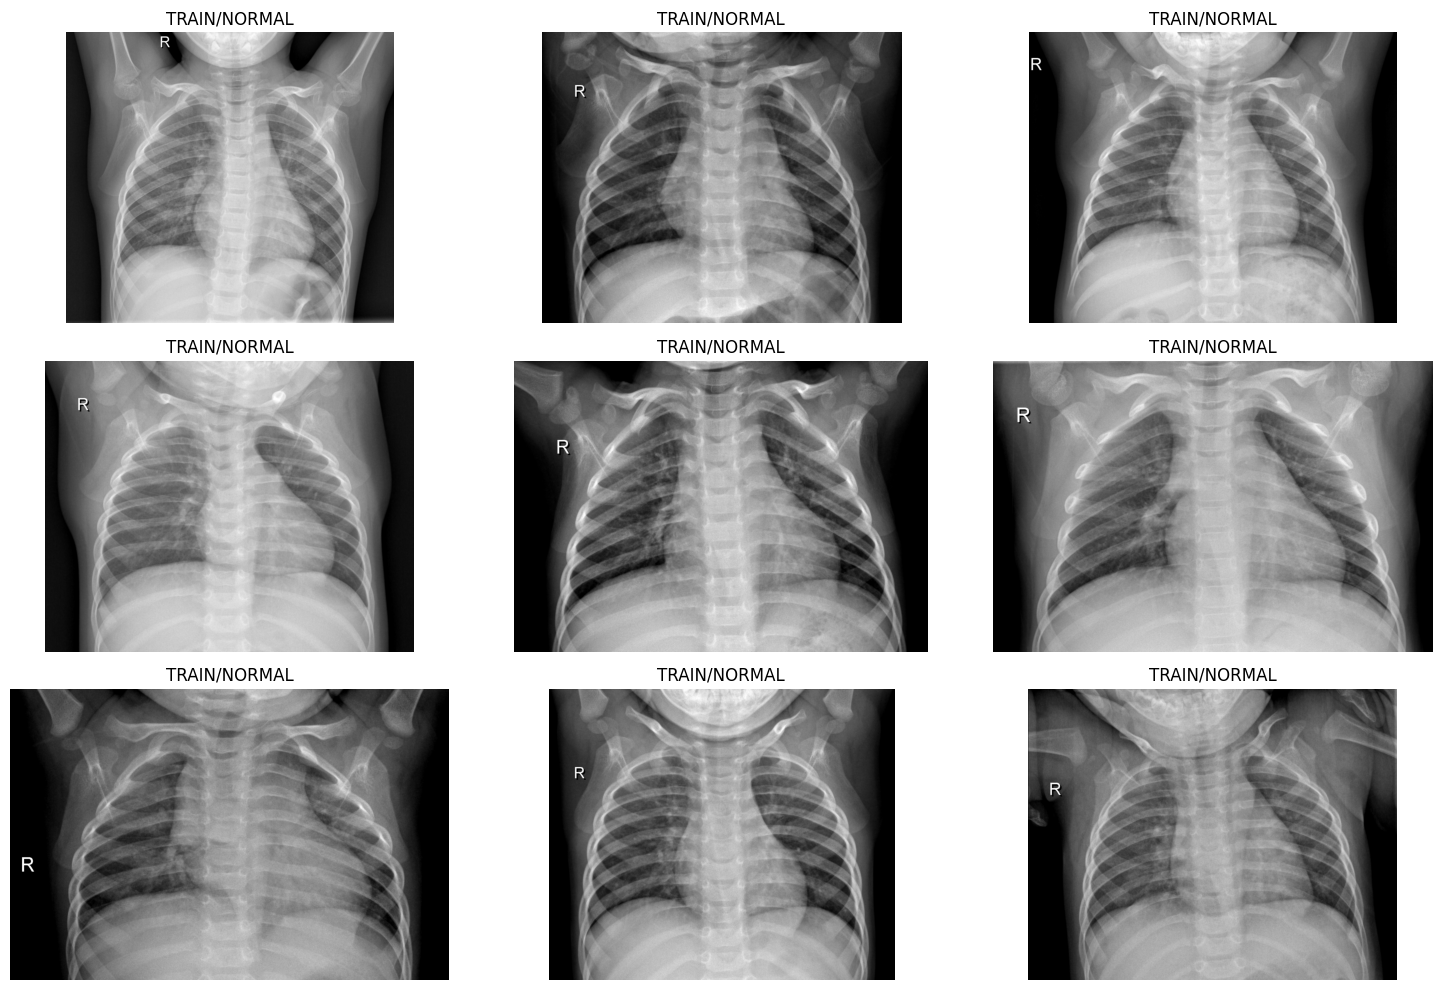

In [8]:
# Define dataset path
base_path = r'C:\Users\WW\pneumonia_xray_project\data\raw\chest_xray'

# Function to load all images recursively with labels
def load_full_dataset(base_path):
    all_images = []
    for dataset_type in ["train", "test", "val"]:  # Include validation if exists
        dataset_path = os.path.join(base_path, dataset_type)
        if not os.path.exists(dataset_path):
            continue
        # Loop over categories (NORMAL, PNEUMONIA, etc.)
        for label in os.listdir(dataset_path):
            label_path = os.path.join(dataset_path, label)
            if not os.path.isdir(label_path):
                continue
            # Load all images in this label folder
            for img_file in glob(os.path.join(label_path, "*")):
                try:
                    img = Image.open(img_file)
                    all_images.append((img, label.upper(), dataset_type.upper(), img_file))
                except Exception as e:
                    print(f"Error loading {img_file}: {e}")
    return all_images

# Load dataset
dataset = load_full_dataset(base_path)
print(f"Total images loaded: {len(dataset)}")

# Optional: count per category
from collections import Counter
category_counts = Counter((label, dataset_type) for _, label, dataset_type, _ in dataset)
print("Category counts:")
for (label, dataset_type), count in category_counts.items():
    print(f"{dataset_type}/{label}: {count}")

# Optional: display sample images
plt.figure(figsize=(15, 10))
for i, (img, label, dataset_type, path) in enumerate(dataset[:9]):  # show first 9
    plt.subplot(3, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"{dataset_type}/{label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
import hashlib
import os

def get_image_hash(img):
    """Return a hash for an image based on its content"""
    # Convert to grayscale & resize (smaller = faster)
    img = img.convert("L").resize((128, 128))
    return hashlib.md5(img.tobytes()).hexdigest()

def remove_duplicates(dataset):
    """Remove exact duplicate images from a dataset"""
    seen = {}
    unique_dataset = []
    duplicates = []

    for img, label, dataset_type, path in dataset:
        try:
            img_hash = get_image_hash(img)
            if img_hash not in seen:
                seen[img_hash] = path
                unique_dataset.append((img, label, dataset_type, path))
            else:
                duplicates.append(path)
        except Exception as e:
            print(f"Error hashing {path}: {e}")

    return unique_dataset, duplicates
    # Remove duplicates
unique_dataset, duplicates = remove_duplicates(dataset)

print(f"Total images before removing duplicates: {len(dataset)}")
print(f"Duplicates found and removed: {len(duplicates)}")
print(f"Total images after removing duplicates: {len(unique_dataset)}")


Total images before removing duplicates: 5834
Duplicates found and removed: 10
Total images after removing duplicates: 5824


In [10]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [12]:
import os
from glob import glob
from PIL import Image, ImageOps, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
import cv2  # OpenCV for noise/contrast handling
import shutil

# Define dataset path
base_path = r'C:\Users\WW\pneumonia_xray_project\data\raw\chest_xray'

# -------------------------
# 1. Removing Corrupted Files
# -------------------------
def check_and_load_images(path_pattern):
    """Load images and skip corrupted ones"""
    valid_images = []
    bad_files = []
    for img_path in glob(path_pattern):
        try:
            with Image.open(img_path) as img:
                img.verify()  # Verify image integrity
            valid_images.append(img_path)
        except Exception:
            bad_files.append(img_path)
    return valid_images, bad_files

# -------------------------
# 2. Standardize Image Size
# -------------------------
def resize_image(img, size=(224, 224)):
    return img.resize(size, Image.Resampling.LANCZOS)

# -------------------------
# 3. Scale Pixel Values (0-1)
# -------------------------
def scale_pixels(img):
    arr = np.array(img).astype("float32") / 255.0
    return arr

# -------------------------
# 4. Noise Handling (Denoising)
# -------------------------
def denoise_image(img_arr):
    img_uint8 = (img_arr * 255).astype("uint8")
    denoised = cv2.fastNlMeansDenoising(img_uint8, None, h=30)
    return denoised.astype("float32") / 255.0

# -------------------------
# 5. Contrast & Lighting Adjustments
# -------------------------
def enhance_contrast(img):
    enhancer = ImageEnhance.Contrast(img)
    return enhancer.enhance(1.5)  # Increase contrast

def adjust_brightness(img):
    enhancer = ImageEnhance.Brightness(img)
    return enhancer.enhance(1.2)  # Slightly brighter

# -------------------------
# NEW: Preprocess & Save Function
# -------------------------
def preprocess_and_save(img_path, save_path):
    try:
        img = Image.open(img_path).convert("L")   # Grayscale
        img = resize_image(img)                   # Resize
        arr = scale_pixels(img)                   # Scale
        arr = denoise_image(arr)                  # Denoise
        img = Image.fromarray((arr * 255).astype("uint8"))  # Back to PIL
        img = enhance_contrast(img)               # Contrast
        img = adjust_brightness(img)              # Brightness
        img.save(save_path)
    except Exception as e:
        print(f"Skipping {img_path}: {e}")

# -------------------------
# Process Whole Dataset
# -------------------------
output_dir = "processed_dataset"
os.makedirs(output_dir, exist_ok=True)

for dataset_type in ["train", "test", "val"]:
    for label in ["NORMAL", "PNEUMONIA"]:
        input_dir = os.path.join(base_path, dataset_type, label)
        output_subdir = os.path.join(output_dir, dataset_type, label)
        os.makedirs(output_subdir, exist_ok=True)

        valid_images, _ = check_and_load_images(os.path.join(input_dir, "*.jpeg"))
        print(f"Processing {len(valid_images)} images from {dataset_type}/{label}...")

        for idx, img_path in enumerate(valid_images):
            save_path = os.path.join(output_subdir, f"img_{idx}.jpg")
            preprocess_and_save(img_path, save_path)

print("✅ All images processed and saved!")

# -------------------------
# Create Zip for Download
# -------------------------
shutil.make_archive("processed_dataset", 'zip', output_dir)
print("✅ processed_dataset.zip is ready for download")


Processing 1341 images from train/NORMAL...
Processing 3859 images from train/PNEUMONIA...
Processing 231 images from test/NORMAL...
Processing 387 images from test/PNEUMONIA...
Processing 8 images from val/NORMAL...
Processing 8 images from val/PNEUMONIA...
✅ All images processed and saved!
✅ processed_dataset.zip is ready for download
